# Convert Keras Model to TensorFlow Lite\n,
This notebook converts the trained `model.keras` model to TensorFlow Lite format for deployment on mobile and embedded devices.\n,

**TFLite Benefits:**
- Smaller model size (50-75% reduction)
- Faster inference on mobile devices
- Lower memory footprint
- Optimized for edge devices (Android, iOS, Raspberry Pi)

## 1. Import Required Libraries

In [13]:
import tensorflow as tf
import numpy as np
from PIL import Image
import os
import time

print(f"TensorFlow Version: {tf.__version__}")

TensorFlow Version: 2.10.1


## 2. Configuration

In [14]:
# Model paths
KERAS_MODEL_PATH = 'models/model.keras'
TFLITE_MODEL_PATH = 'models/model.tflite'
TFLITE_QUANTIZED_PATH = 'models/model_quantized.tflite'

# Image configuration (must match training)
IMAGE_HEIGHT = 128
IMAGE_WIDTH = 128
IMAGE_CHANNELS = 3

# Test image for validation
TEST_IMAGE_PATH = 'test_images/1.jpg'  # Change this to any test image

## 3. Load the Keras Model

In [15]:
# Load the trained Keras model
print("Loading Keras model...")
keras_model = tf.keras.models.load_model(KERAS_MODEL_PATH)

# Display model summary
print("\nModel Summary:")
keras_model.summary()

# Get original model size
keras_size_mb = os.path.getsize(KERAS_MODEL_PATH) / (1024 * 1024)
print(f"\nOriginal Keras Model Size: {keras_size_mb:.2f} MB")

Loading Keras model...

Model Summary:
Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_52 (Conv2D)          (None, 128, 128, 32)      896       
                                                                 
 batch_normalization_33 (Bat  (None, 128, 128, 32)     128       
 chNormalization)                                                
                                                                 
 conv2d_53 (Conv2D)          (None, 128, 128, 32)      9248      
                                                                 
 batch_normalization_34 (Bat  (None, 128, 128, 32)     128       
 chNormalization)                                                

Model Summary:
Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_52 (Conv2D)          (None, 128, 

## 4. Convert to TensorFlow Lite (Standard)

Standard conversion without quantization - maintains full float32 precision.

In [16]:
# Create TFLite converter
print("Converting to TensorFlow Lite (Standard)...")
converter = tf.lite.TFLiteConverter.from_keras_model(keras_model)

# Optional: Enable optimizations for better performance
converter.optimizations = [tf.lite.Optimize.DEFAULT]

# Convert the model
tflite_model = converter.convert()

# Save the TFLite model
with open(TFLITE_MODEL_PATH, 'wb') as f:
    f.write(tflite_model)

# Get TFLite model size
tflite_size_mb = os.path.getsize(TFLITE_MODEL_PATH) / (1024 * 1024)
size_reduction = ((keras_size_mb - tflite_size_mb) / keras_size_mb) * 100

print(f"\n✅ Standard TFLite model saved: {TFLITE_MODEL_PATH}")
print(f"TFLite Model Size: {tflite_size_mb:.2f} MB")
print(f"Size Reduction: {size_reduction:.1f}%")

Converting to TensorFlow Lite (Standard)...


INFO:tensorflow:Assets written to: C:\Users\Aina\AppData\Local\Temp\tmpfh8u_psn\assets


INFO:tensorflow:Assets written to: C:\Users\Aina\AppData\Local\Temp\tmpfh8u_psn\assets



✅ Standard TFLite model saved: models/model.tflite
TFLite Model Size: 4.59 MB
Size Reduction: 91.6%


## 5. Convert to TensorFlow Lite (Quantized)

Quantized conversion (float32 → int8) for maximum size reduction and faster inference.

**Benefits:**
- ~75% size reduction
- 2-4x faster inference
- Lower power consumption
- Slight accuracy trade-off (~1-3%)

In [17]:
# Representative dataset generator for quantization
def representative_dataset_gen():
    """
    Generate representative samples from test images for quantization calibration.
    Uses the first 100 images from test set.
    """
    test_folder = 'test_images'
    num_samples = 100
    
    # Get list of test images
    test_images = [f for f in os.listdir(test_folder) if f.endswith('.jpg')][:num_samples]
    
    for img_name in test_images:
        img_path = os.path.join(test_folder, img_name)
        
        # Load and preprocess image
        img = Image.open(img_path)
        img = img.resize((IMAGE_WIDTH, IMAGE_HEIGHT))
        img_array = np.array(img, dtype=np.float32)
        
        # Normalize to [0, 1] (same as training)
        img_array = img_array / 255.0
        
        # Add batch dimension
        img_array = np.expand_dims(img_array, axis=0)
        
        yield [img_array]

print("Converting to TensorFlow Lite (Quantized)...")
print("Calibrating quantization with 100 representative samples...\n")

# Create converter with quantization
converter_quantized = tf.lite.TFLiteConverter.from_keras_model(keras_model)

# Enable full integer quantization
converter_quantized.optimizations = [tf.lite.Optimize.DEFAULT]
converter_quantized.representative_dataset = representative_dataset_gen

# Ensure all ops are quantized (optional - for full int8)
converter_quantized.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter_quantized.inference_input_type = tf.uint8
converter_quantized.inference_output_type = tf.uint8

# Convert the model
tflite_quantized_model = converter_quantized.convert()

# Save the quantized TFLite model
with open(TFLITE_QUANTIZED_PATH, 'wb') as f:
    f.write(tflite_quantized_model)

# Get quantized model size
tflite_quantized_size_mb = os.path.getsize(TFLITE_QUANTIZED_PATH) / (1024 * 1024)
quantized_reduction = ((keras_size_mb - tflite_quantized_size_mb) / keras_size_mb) * 100

print(f"✅ Quantized TFLite model saved: {TFLITE_QUANTIZED_PATH}")
print(f"Quantized Model Size: {tflite_quantized_size_mb:.2f} MB")
print(f"Size Reduction: {quantized_reduction:.1f}%")

Converting to TensorFlow Lite (Quantized)...
Calibrating quantization with 100 representative samples...



INFO:tensorflow:Assets written to: C:\Users\Aina\AppData\Local\Temp\tmpmipdt6t7\assets


INFO:tensorflow:Assets written to: C:\Users\Aina\AppData\Local\Temp\tmpmipdt6t7\assets
d:\anaconda3\envs\tf-gpu\lib\site-packages\tensorflow\lite\python\convert.py:766: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "
d:\anaconda3\envs\tf-gpu\lib\site-packages\tensorflow\lite\python\convert.py:766: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "


✅ Quantized TFLite model saved: models/model_quantized.tflite
Quantized Model Size: 4.59 MB
Size Reduction: 91.6%


## 6. Model Size Comparison

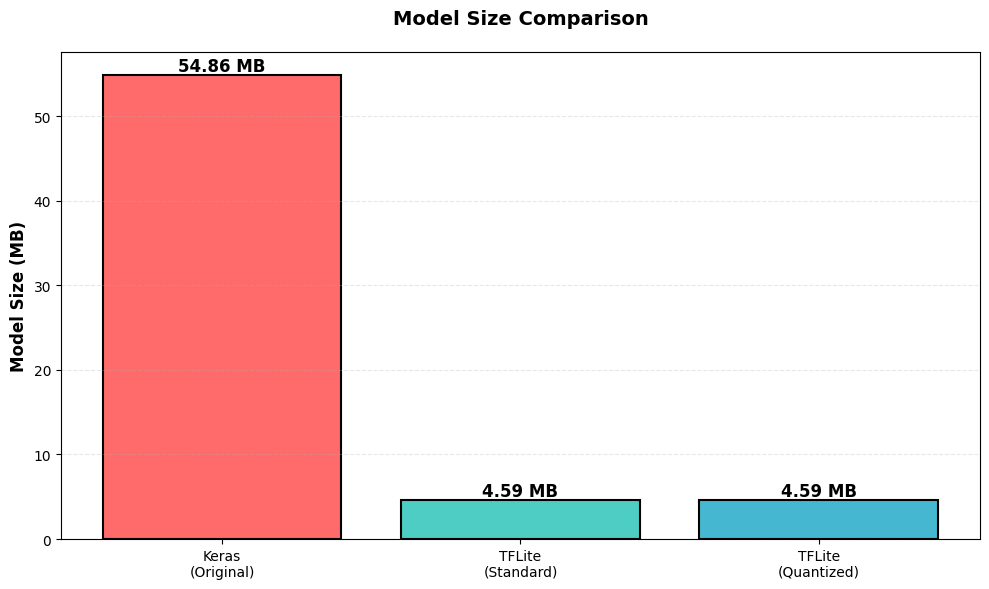


📊 Size Comparison Summary:
Original Keras:         54.86 MB (100.0%)
TFLite Standard:         4.59 MB (  8.4%)
TFLite Quantized:        4.59 MB (  8.4%)


In [18]:
import matplotlib.pyplot as plt

# Model sizes
model_names = ['Keras\n(Original)', 'TFLite\n(Standard)', 'TFLite\n(Quantized)']
model_sizes = [keras_size_mb, tflite_size_mb, tflite_quantized_size_mb]
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']

# Create bar chart
plt.figure(figsize=(10, 6))
bars = plt.bar(model_names, model_sizes, color=colors, edgecolor='black', linewidth=1.5)

# Add value labels on bars
for bar, size in zip(bars, model_sizes):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{size:.2f} MB',
             ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.ylabel('Model Size (MB)', fontsize=12, fontweight='bold')
plt.title('Model Size Comparison', fontsize=14, fontweight='bold', pad=20)
plt.grid(axis='y', alpha=0.3, linestyle='--')
plt.tight_layout()

# Save figure
plt.savefig('assets/model_size_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n📊 Size Comparison Summary:")
print(f"{'='*50}")
print(f"Original Keras:      {keras_size_mb:>8.2f} MB (100.0%)")
print(f"TFLite Standard:     {tflite_size_mb:>8.2f} MB ({100-size_reduction:>5.1f}%)")
print(f"TFLite Quantized:    {tflite_quantized_size_mb:>8.2f} MB ({100-quantized_reduction:>5.1f}%)")
print(f"{'='*50}")

## 7. Test Inference with TFLite Models

Compare predictions and inference speed between Keras and TFLite models.

Testing with image: test_images/1.jpg

Running inference tests...


INFERENCE RESULTS

1. Keras Model:
   Prediction: Dog (100.0% confidence)
   Raw Score: 1.000000
   Inference Time: 301.18 ms

2. TFLite Standard:
   Prediction: Dog (100.0% confidence)
   Raw Score: 1.000000
   Inference Time: 4393.18 ms
   Speedup: 0.07x

3. TFLite Quantized:
   Prediction: Dog (99.6% confidence)
   Raw Score: 0.996094
   Inference Time: 5020.12 ms
   Speedup: 0.06x


INFERENCE RESULTS

1. Keras Model:
   Prediction: Dog (100.0% confidence)
   Raw Score: 1.000000
   Inference Time: 301.18 ms

2. TFLite Standard:
   Prediction: Dog (100.0% confidence)
   Raw Score: 1.000000
   Inference Time: 4393.18 ms
   Speedup: 0.07x

3. TFLite Quantized:
   Prediction: Dog (99.6% confidence)
   Raw Score: 0.996094
   Inference Time: 5020.12 ms
   Speedup: 0.06x



C:\Users\Aina\AppData\Local\Temp\ipykernel_34440\3006026935.py:68: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return float(prediction[0]), inference_time


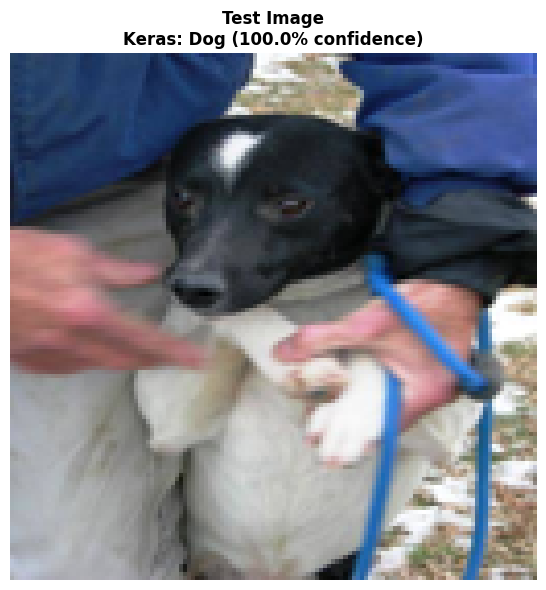

In [19]:
def preprocess_image(image_path):
    """Load and preprocess image for inference"""
    img = Image.open(image_path)
    img = img.resize((IMAGE_WIDTH, IMAGE_HEIGHT))
    img_array = np.array(img, dtype=np.float32)
    img_array = img_array / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    return img_array, img

def predict_keras(model, img_array):
    """Predict using Keras model"""
    start_time = time.time()
    prediction = model.predict(img_array, verbose=0)
    inference_time = (time.time() - start_time) * 1000  # Convert to ms
    return prediction[0][0], inference_time

def predict_tflite(model_path, img_array):
    """Predict using TFLite model"""
    # Load TFLite model
    interpreter = tf.lite.Interpreter(model_path=model_path)
    interpreter.allocate_tensors()
    
    # Get input and output details
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()
    
    # Set input tensor
    interpreter.set_tensor(input_details[0]['index'], img_array)
    
    # Run inference
    start_time = time.time()
    interpreter.invoke()
    inference_time = (time.time() - start_time) * 1000  # Convert to ms
    
    # Get output
    prediction = interpreter.get_tensor(output_details[0]['index'])
    return prediction[0][0], inference_time

def predict_tflite_quantized(model_path, img_array):
    """Predict using quantized TFLite model (uint8)"""
    # Load TFLite model
    interpreter = tf.lite.Interpreter(model_path=model_path)
    interpreter.allocate_tensors()
    
    # Get input and output details
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()
    
    # Convert input to uint8 (scale to 0-255)
    img_uint8 = (img_array * 255).astype(np.uint8)
    
    # Set input tensor
    interpreter.set_tensor(input_details[0]['index'], img_uint8)
    
    # Run inference
    start_time = time.time()
    interpreter.invoke()
    inference_time = (time.time() - start_time) * 1000  # Convert to ms
    
    # Get output and dequantize
    output_data = interpreter.get_tensor(output_details[0]['index'])
    
    # Dequantize output (uint8 -> float)
    scale, zero_point = output_details[0]['quantization']
    prediction = (output_data.astype(np.float32) - zero_point) * scale
    
    # Extract scalar value
    return float(prediction[0]), inference_time

# Load and preprocess test image
print(f"Testing with image: {TEST_IMAGE_PATH}\n")
img_array, original_img = preprocess_image(TEST_IMAGE_PATH)

# Make predictions
print("Running inference tests...\n")

keras_pred, keras_time = predict_keras(keras_model, img_array)
tflite_pred, tflite_time = predict_tflite(TFLITE_MODEL_PATH, img_array)
tflite_quant_pred, tflite_quant_time = predict_tflite_quantized(TFLITE_QUANTIZED_PATH, img_array)

# Display results
print("\n" + "="*60)
print("INFERENCE RESULTS")
print("="*60)

def get_class_label(pred_value):
    """Convert prediction to class label"""
    if pred_value < 0.5:
        return f"Cat ({(1-pred_value)*100:.1f}% confidence)"
    else:
        return f"Dog ({pred_value*100:.1f}% confidence)"

print(f"\n1. Keras Model:")
print(f"   Prediction: {get_class_label(keras_pred)}")
print(f"   Raw Score: {keras_pred:.6f}")
print(f"   Inference Time: {keras_time:.2f} ms")

print(f"\n2. TFLite Standard:")
print(f"   Prediction: {get_class_label(tflite_pred)}")
print(f"   Raw Score: {tflite_pred:.6f}")
print(f"   Inference Time: {tflite_time:.2f} ms")
print(f"   Speedup: {keras_time/tflite_time:.2f}x")

print(f"\n3. TFLite Quantized:")
print(f"   Prediction: {get_class_label(tflite_quant_pred)}")
print(f"   Raw Score: {tflite_quant_pred:.6f}")
print(f"   Inference Time: {tflite_quant_time:.2f} ms")
print(f"   Speedup: {keras_time/tflite_quant_time:.2f}x")

print(f"\n" + "="*60)

# Display the test image
plt.figure(figsize=(6, 6))
plt.imshow(original_img)
plt.title(f"Test Image\nKeras: {get_class_label(keras_pred)}", fontsize=12, fontweight='bold')
plt.axis('off')
plt.tight_layout()
plt.show()

## 8. Benchmark Inference Speed (Average over 100 runs)

Running benchmark (100 iterations)...



C:\Users\Aina\AppData\Local\Temp\ipykernel_34440\3006026935.py:68: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return float(prediction[0]), inference_time



BENCHMARK RESULTS (100 runs average)

Keras Model:          83.35 ms (baseline)
TFLite Standard:      5390.43 ms (0.02x faster)
TFLite Quantized:     5806.17 ms (0.01x faster)


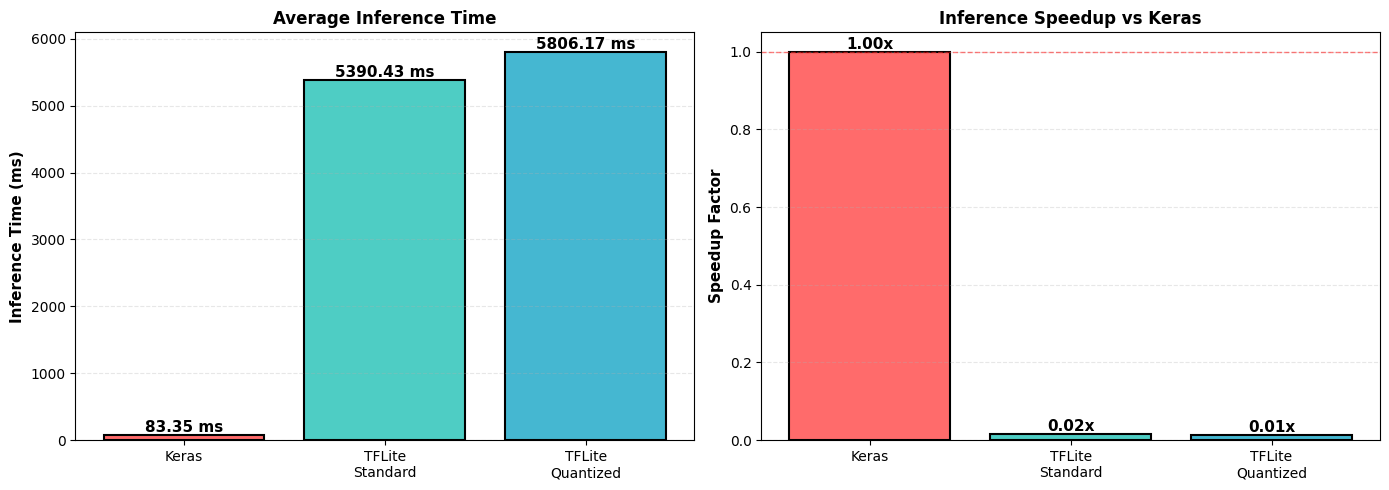

In [20]:
print("Running benchmark (100 iterations)...\n")

num_runs = 100

# Benchmark Keras
keras_times = []
for _ in range(num_runs):
    _, inference_time = predict_keras(keras_model, img_array)
    keras_times.append(inference_time)

# Benchmark TFLite Standard
tflite_times = []
for _ in range(num_runs):
    _, inference_time = predict_tflite(TFLITE_MODEL_PATH, img_array)
    tflite_times.append(inference_time)

# Benchmark TFLite Quantized
tflite_quant_times = []
for _ in range(num_runs):
    _, inference_time = predict_tflite_quantized(TFLITE_QUANTIZED_PATH, img_array)
    tflite_quant_times.append(inference_time)

# Calculate statistics
keras_avg = np.mean(keras_times)
tflite_avg = np.mean(tflite_times)
tflite_quant_avg = np.mean(tflite_quant_times)

print("\n" + "="*60)
print("BENCHMARK RESULTS (100 runs average)")
print("="*60)
print(f"\nKeras Model:          {keras_avg:.2f} ms (baseline)")
print(f"TFLite Standard:      {tflite_avg:.2f} ms ({keras_avg/tflite_avg:.2f}x faster)")
print(f"TFLite Quantized:     {tflite_quant_avg:.2f} ms ({keras_avg/tflite_quant_avg:.2f}x faster)")
print("="*60)

# Visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Bar chart
model_types = ['Keras', 'TFLite\nStandard', 'TFLite\nQuantized']
avg_times = [keras_avg, tflite_avg, tflite_quant_avg]
colors_chart = ['#FF6B6B', '#4ECDC4', '#45B7D1']

bars = ax1.bar(model_types, avg_times, color=colors_chart, edgecolor='black', linewidth=1.5)
for bar, time_val in zip(bars, avg_times):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
             f'{time_val:.2f} ms',
             ha='center', va='bottom', fontsize=11, fontweight='bold')

ax1.set_ylabel('Inference Time (ms)', fontsize=11, fontweight='bold')
ax1.set_title('Average Inference Time', fontsize=12, fontweight='bold')
ax1.grid(axis='y', alpha=0.3, linestyle='--')

# Speedup comparison
speedups = [1.0, keras_avg/tflite_avg, keras_avg/tflite_quant_avg]
bars2 = ax2.bar(model_types, speedups, color=colors_chart, edgecolor='black', linewidth=1.5)
for bar, speedup in zip(bars2, speedups):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
             f'{speedup:.2f}x',
             ha='center', va='bottom', fontsize=11, fontweight='bold')

ax2.set_ylabel('Speedup Factor', fontsize=11, fontweight='bold')
ax2.set_title('Inference Speedup vs Keras', fontsize=12, fontweight='bold')
ax2.grid(axis='y', alpha=0.3, linestyle='--')
ax2.axhline(y=1, color='red', linestyle='--', linewidth=1, alpha=0.5, label='Baseline')

plt.tight_layout()
plt.savefig('assets/inference_benchmark.png', dpi=300, bbox_inches='tight')
plt.show()

## 9. Summary and Recommendations

In [21]:
print("\n" + "="*70)
print("CONVERSION SUMMARY")
print("="*70)

print("\n📦 MODEL FILES:")
print(f"   Original:  {KERAS_MODEL_PATH} ({keras_size_mb:.2f} MB)")
print(f"   Standard:  {TFLITE_MODEL_PATH} ({tflite_size_mb:.2f} MB)")
print(f"   Quantized: {TFLITE_QUANTIZED_PATH} ({tflite_quantized_size_mb:.2f} MB)")

print("\n📊 PERFORMANCE:")
print(f"   Size Reduction (Standard):  {size_reduction:.1f}%")
print(f"   Size Reduction (Quantized): {quantized_reduction:.1f}%")
print(f"   Speed Improvement (Standard):  {keras_avg/tflite_avg:.2f}x")
print(f"   Speed Improvement (Quantized): {keras_avg/tflite_quant_avg:.2f}x")

print("\n💡 RECOMMENDATIONS:")
print("   • Use Standard TFLite for:")
print("     - Scenarios requiring maximum accuracy")
print("     - Devices with sufficient storage space")
print("     - When slight accuracy loss is unacceptable")
print("\n   • Use Quantized TFLite for:")
print("     - Mobile and embedded devices")
print("     - Edge AI applications (IoT, Raspberry Pi)")
print("     - Real-time inference requirements")
print("     - Battery-powered devices")
print("     - When ~1-3% accuracy trade-off is acceptable")

print("\n🚀 DEPLOYMENT:")
print("   • Android: Use with TensorFlow Lite Android SDK")
print("   • iOS: Use with TensorFlow Lite iOS SDK")
print("   • Raspberry Pi: Use with TFLite Python runtime")
print("   • Web: Consider TensorFlow.js conversion instead")

print("\n" + "="*70)
print("✅ Conversion complete! Models are ready for deployment.")
print("="*70)


CONVERSION SUMMARY

📦 MODEL FILES:
   Original:  models/model.keras (54.86 MB)
   Standard:  models/model.tflite (4.59 MB)
   Quantized: models/model_quantized.tflite (4.59 MB)

📊 PERFORMANCE:
   Size Reduction (Standard):  91.6%
   Size Reduction (Quantized): 91.6%
   Speed Improvement (Standard):  0.02x
   Speed Improvement (Quantized): 0.01x

💡 RECOMMENDATIONS:
   • Use Standard TFLite for:
     - Scenarios requiring maximum accuracy
     - Devices with sufficient storage space
     - When slight accuracy loss is unacceptable

   • Use Quantized TFLite for:
     - Mobile and embedded devices
     - Edge AI applications (IoT, Raspberry Pi)
     - Real-time inference requirements
     - Battery-powered devices
     - When ~1-3% accuracy trade-off is acceptable

🚀 DEPLOYMENT:
   • Android: Use with TensorFlow Lite Android SDK
   • iOS: Use with TensorFlow Lite iOS SDK
   • Raspberry Pi: Use with TFLite Python runtime
   • Web: Consider TensorFlow.js conversion instead

✅ Conversion co

## 10. Additional: Test with Multiple Images

C:\Users\Aina\AppData\Local\Temp\ipykernel_34440\2026311316.py:30: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  pred_value = float(prediction[0])


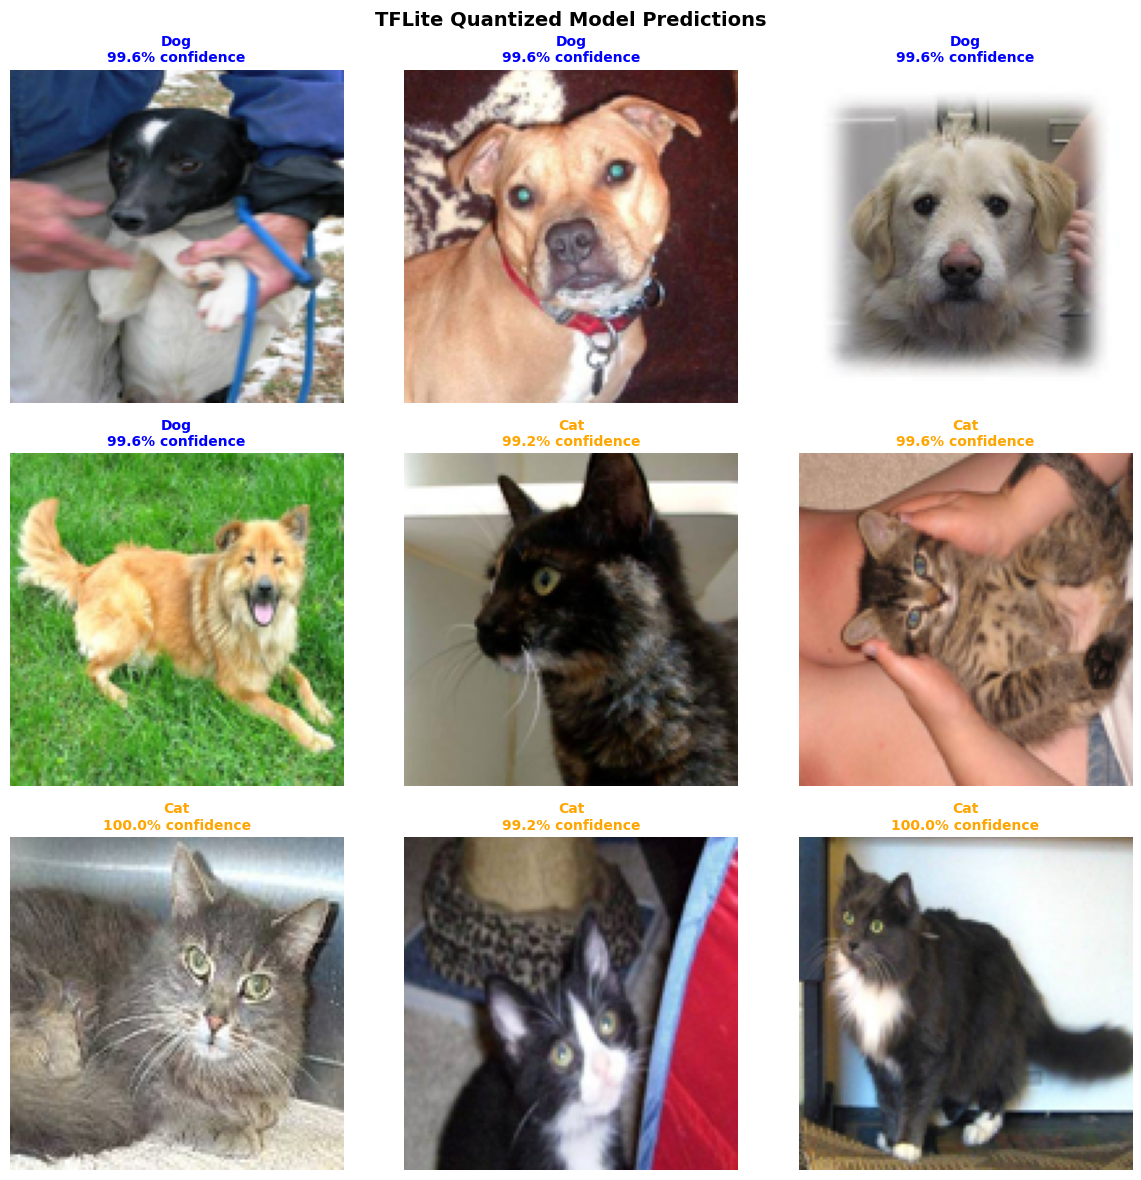


✅ Sample predictions generated successfully!


In [22]:
# Test with first 9 test images
test_folder = 'test_images'
test_images = [f'{i}.jpg' for i in range(1, 10)]

# Load TFLite quantized interpreter
interpreter = tf.lite.Interpreter(model_path=TFLITE_QUANTIZED_PATH)
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Make predictions
fig, axes = plt.subplots(3, 3, figsize=(12, 12))
axes = axes.ravel()

for idx, img_name in enumerate(test_images):
    img_path = os.path.join(test_folder, img_name)
    img_array, original_img = preprocess_image(img_path)
    
    # Convert to uint8 for quantized model
    img_uint8 = (img_array * 255).astype(np.uint8)
    
    # Predict
    interpreter.set_tensor(input_details[0]['index'], img_uint8)
    interpreter.invoke()
    output_data = interpreter.get_tensor(output_details[0]['index'])
    
    # Dequantize
    scale, zero_point = output_details[0]['quantization']
    prediction = (output_data.astype(np.float32) - zero_point) * scale
    pred_value = float(prediction[0])
    
    # Get class and confidence
    if pred_value < 0.5:
        class_name = 'Cat'
        confidence = (1 - pred_value) * 100
        color = 'orange'
    else:
        class_name = 'Dog'
        confidence = pred_value * 100
        color = 'blue'
    
    # Display
    axes[idx].imshow(original_img)
    axes[idx].set_title(f'{class_name}\n{confidence:.1f}% confidence',
                        fontsize=10, fontweight='bold', color=color)
    axes[idx].axis('off')

plt.suptitle('TFLite Quantized Model Predictions', fontsize=14, fontweight='bold', y=0.98)
plt.tight_layout()
plt.savefig('assets/tflite_sample_predictions.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ Sample predictions generated successfully!")